# Libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["TOKENIZERS_PARALLELISM"] = "False" # export NUMEXPR_NUM_THREADS=1

In [2]:
import TELF;TELF.__version__

'0.0.42'

In [3]:
import pandas as pd
from IPython.display import Image

In [4]:
from TELF.pre_processing import Vulture
from TELF.pre_processing.Vulture.modules import SimpleCleaner
from TELF.pre_processing.Vulture.modules import LemmatizeCleaner
from TELF.pre_processing.Vulture.modules import RemoveNonEnglishCleaner
from TELF.pre_processing.Vulture.default_stop_words import STOP_WORDS
from TELF.pre_processing.Vulture.default_stop_phrases import STOP_PHRASES

In [5]:
from TELF.factorization import NMFk

In [6]:
from TELF.pre_processing import Beaver

In [7]:
from TELF.post_processing import Fox

# Load Data

In [8]:
df_path = os.path.join("..", "..", "data", "sample2.csv")
df = pd.read_csv(df_path)
df = df.dropna(subset=['title', 'abstract'])
df = df.head(50).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   eid               50 non-null     object 
 1   s2id              50 non-null     object 
 2   doi               50 non-null     object 
 3   title             50 non-null     object 
 4   abstract          50 non-null     object 
 5   year              50 non-null     int64  
 6   authors           50 non-null     object 
 7   author_ids        50 non-null     object 
 8   affiliations      50 non-null     object 
 9   funding           5 non-null      object 
 10  PACs              8 non-null      object 
 11  publication_name  50 non-null     object 
 12  subject_areas     50 non-null     object 
 13  s2_authors        50 non-null     object 
 14  s2_author_ids     50 non-null     object 
 15  citations         45 non-null     object 
 16  references        38 non-null     object 
 17 

# Clean Text

In [9]:
# Define a sequential list of text cleaning steps to preprocess documents
steps = [

    # Step 1: Filter out non-English or low-quality text
    RemoveNonEnglishCleaner(
        ascii_ratio=0.9,           # At least 90% of characters must be ASCII
        stopwords_ratio=0.25       # At least 25% of tokens must be stopwords (a proxy for English text)
    ),

    # Step 2: Apply a series of cleaning rules in a defined order
    SimpleCleaner(
        stop_words=STOP_WORDS,            # Custom list of stop words to remove
        stop_phrases=STOP_PHRASES,        # Phrases to eliminate (e.g., boilerplate)
        order=[
            'standardize_hyphens',        # Normalize hyphens and dashes
            'isolate_frozen',             # Flag frozen phrases (optional domain-specific handling)
            'remove_copyright_statement', # Remove common copyright/license headers
            'remove_stop_phrases',        # Remove specific, known non-informative phrases
            'make_lower_case',            # Convert text to lowercase
            'remove_formulas',            # Remove formula-like tokens (e.g., math expressions)
            'normalize',                  # Normalize unicode, spacing, and punctuation
            'remove_next_line',           # Flatten newlines
            'remove_email',               # Remove email addresses
            'remove_()',                  # Remove parentheses and content inside
            'remove_[]',                  # Remove brackets and content inside
            'remove_special_characters',  # Remove symbols and non-alphanumeric characters
            'remove_nonASCII_boundary',   # Remove non-ASCII characters at text boundaries
            'remove_nonASCII',            # Remove all non-ASCII characters
            'remove_tags',                # Remove HTML/XML-style tags
            'remove_stop_words',          # Remove stop words using provided list
            'remove_standalone_numbers',  # Remove numeric tokens not part of words
            'remove_extra_whitespace',    # Normalize spacing
            'min_characters',             # Discard text blocks below a minimum character length
        ]
    ),

    # Step 3: Lemmatization using spaCy
    LemmatizeCleaner('spacy')  # Converts words to their base form (e.g., "running" → "run")
]


In [10]:
# Set the output directory and path to save the cleaned DataFrame
RESULTS = "result_example"
os.makedirs(RESULTS, exist_ok=True)  # Create the directory if it doesn't already exist
df_clean_path = os.path.join(RESULTS, 'clean_df.csv')  # Path to save the cleaned CSV

# Initialize the Vulture text cleaner
vulture = Vulture(
    n_jobs=1,      # Run cleaning sequentially (set >1 to parallelize across CPUs)
    verbose=10     # Verbosity level for detailed logging
)

# Clean the 'title' and 'abstract' columns in the DataFrame
df = vulture.clean_dataframe(
    df=df,                                 # Input DataFrame
    columns=["title", "abstract"],         # Columns to clean
    append_to_original_df=True,            # Keep original columns in the output
    concat_cleaned_cols=True               # Combine cleaned 'title' and 'abstract' into a single column
)

df.to_csv(df_clean_path, index=False)


[Vulture]: Cleaning 50 documents
100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


# Build The Vocabulary and the Document-Term Matrix

In [11]:
# Column containing the text data to process (e.g., cleaned title + abstract)
DATA_COLUMN = 'clean_title_abstract'

# Keywords to emphasize when vectorizing documents
HIGHLIGHT_WORDS = ['tensor', 'cybersecurity', 'malware', 'analysis']

# Corresponding weights to apply to the highlight words (increase their importance)
HIGHLIGHT_WEIGHTS = [2 for i in HIGHLIGHT_WORDS]  # Uniform weight of 2 for each word

# Initialize Beaver, a utility class for document preprocessing and vectorization
beaver = Beaver()

# Ensure that the RESULTS directory exists for saving outputs
os.makedirs(RESULTS, exist_ok=True)

# Settings to pass to Beaver for TF-IDF matrix generation
settings = {
    "dataset": df,                         # Full DataFrame containing the documents
    "target_column": DATA_COLUMN,          # Column name where document text is located
    "highlighting": HIGHLIGHT_WORDS,       # Words to emphasize in the matrix
    "weights": HIGHLIGHT_WEIGHTS,          # Associated emphasis weights
    "matrix_type": "tfidf",                # Type of document-term matrix to generate
    "save_path": RESULTS                   # Path to optionally save results (if used internally by Beaver)
}

# Generate the document-word matrix (X) and vocabulary
X, vocabulary = beaver.documents_words(**settings)

# Transpose matrix to shape [documents x terms] and convert to efficient sparse row format
X = X.T.tocsr()


# Factorize with NMFk

In [12]:
# Define parameters for the NMFk experiment
params = {
    "n_perturbs": 2,                  # Number of perturbations to test stability
    "n_iters": 250,                     # Iterations per perturbation
    "epsilon": 0.015,                 # Perturbation strength
    "n_jobs": -1,                     # Use all CPU cores
    "init": "nnsvd",                  # Initialization method for NMF
    "use_gpu": False,                 # Use GPU (if available)
    "save_path": RESULTS,            # Base directory to save outputs
    "save_output": True,             # Save model outputs
    "collect_output": True,          # Collect outputs in memory
    "predict_k_method": "sill",      # Use silhouette score to choose k
    "verbose": True,                 # Print progress
    "nmf_verbose": False,            # Print internal NMF logs
    "transpose": False,              # Whether to transpose input matrix
    "sill_thresh": .8,               # Minimum silhouette threshold to accept k
    "pruned": True,                  # Prune low-quality or unstable clusters
    "nmf_method": "nmf_fro_mu",      # NMF solver: Frobenius norm, multiplicative updates
    "calculate_error": True,         # Compute reconstruction error
    "predict_k": True,               # Automatically predict k
    "use_consensus_stopping": 0,     # Not using consensus-based early stopping
    "calculate_pac": False,          # Don't compute PAC score
    "consensus_mat": False,          # Don’t save consensus matrix
    "perturb_type": "uniform",       # Type of noise in perturbation
    "perturb_multiprocessing": False,# Don’t parallelize perturbation (for simplicity/debugging)
    "perturb_verbose": False,        # Suppress perturbation-specific output
    "simple_plot": False,            # Disable simple plot generation
    "k_search_method": "bst_pre",    # Use binary search with pre-checks to find k
    "H_sill_thresh": 0.1,            # Threshold for silhouette over H matrix (for pruning)
    "clustering_method": "kmeans",   # Clustering method used on factor matrix
    "device": -1,                    # -1 = use CPU only
}

# Define the range of k (number of clusters/topics) to explore
Ks = range(1, 10, 1)  # Try k=1 through k=20

# Metadata for experiment tracking
name = "Example_NMFk"
note = "This is an example run of NMFk"

# Instantiate the NMFk model with parameters
model = NMFk(**params)

n_perturbs: 2
perturb_type: uniform
n_iters: 250
epsilon: 0.015
init: nnsvd
save_path: result_example
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.8
predict_k: True
predict_k_method: WH_sill
n_jobs: 192
n_nodes: 1
nmf: <function nmf at 0x79ddcd163060>
nmf_method: nmf_fro_mu
nmf_obj_params: {}
clustering_obj_params: {}
pruned: True
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: False
get_plot_data: False
perturb_multiprocessing: False
k_search_method: bst_pre
H_sill_thresh: 0.1
factor_thresholding: None
factor_thresholding_H_regression: None
factor_thresholding_obj_params: {}
factor_thresholding_H_regression_obj_params: {}
clustering_method: kmeans
device: [-1]
lock: <unlocked _thread.lock object at 0x79dddbb738c0>
K_search_settings: {'lock': <unlocked _thread.lock object at 0x79ddc99c5680>, 'k_search_method': 'bst_pre', 'sil

In [13]:
%time results = model.fit(X, Ks, name, note)

Performing K search with bst_pre. Ks=[5, 3, 2, 1, 4, 8, 7, 6, 9]


  0%|          | 0/9 [00:00<?, ?it/s]/home/barron/miniconda3/envs/dev_artic_fox/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/barron/miniconda3/envs/dev_artic_fox/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


CPU times: user 1.95 s, sys: 718 ms, total: 2.67 s
Wall time: 1.8 s


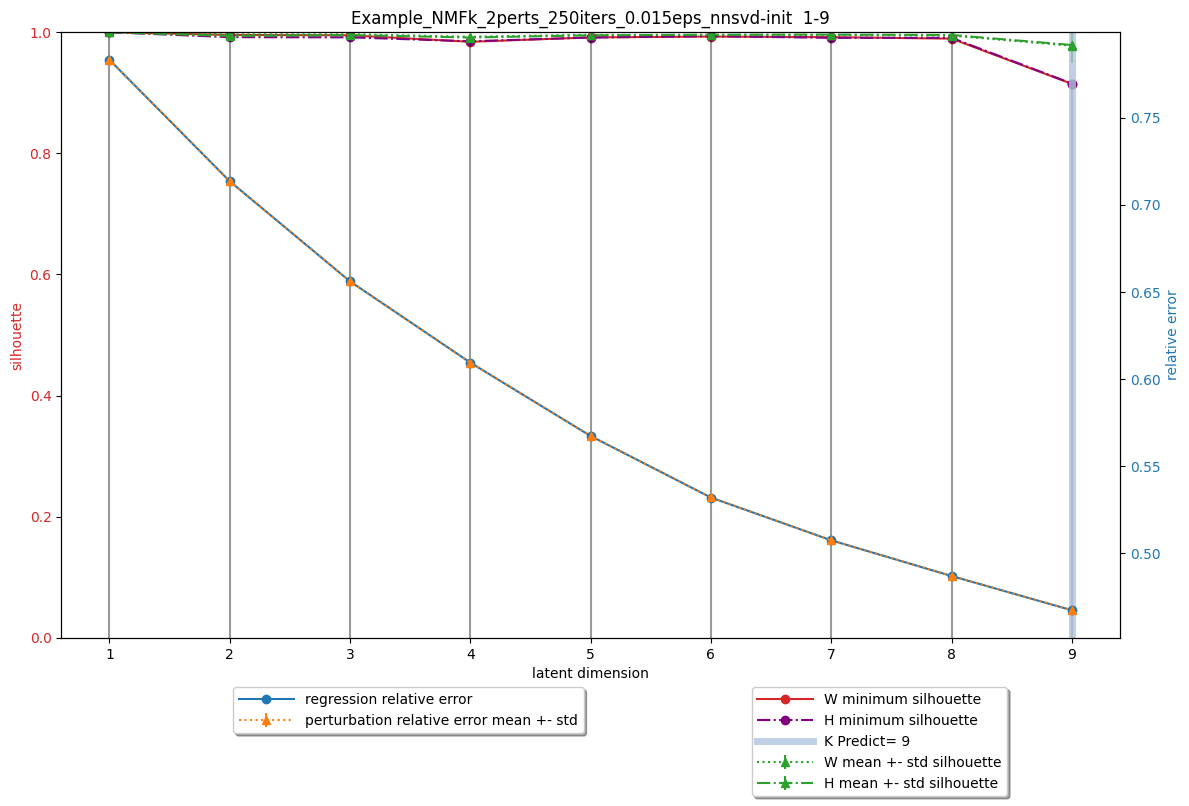

In [14]:
# Display the final plot that compares clustering results for all k
Image(filename=os.path.join(f'{model.save_path_full}', f"FINAL_k={min(Ks)}-{max(Ks)}.png")) 

# Post-process

### Structure directories from hidden topics

In [17]:
W = results['W']
H = results['H']
results.keys()

dict_keys(['time', 'k_predict', 'W', 'H', 'other_results'])

In [ ]:
from TELF.post_processing.ArcticFox import ClusteringAnalyzer

factor_analyzer = ClusteringAnalyzer(
    top_n_words=2,
    out_dir="result_example/ClusteringAnalyzer",
    archive_subdir="archive_factor"
)
out1 = factor_analyzer.analyze(df=df, W=W, H=H, vocab=vocabulary)

100%|██████████| 13/13 [00:00<00:00, 12341.77it/s]


In [ ]:
# Initialize Fox instance
fox = Fox(
    summary_model="gpt-3.5-turbo-instruct",  # LLM used to generate summaries/labels
    verbose=False,                           # Suppress standard output
    debug=True                               # Enable debug logging for inspection
)


### Labels and Summaries

In [ ]:
if "OPENAI_API_KEY" in os.environ:
    print("Found OPENAI_API_KEY environment variable")
    API_KEY = os.environ["OPENAI_API_KEY"]
else:
    print("Variable does not exist. Export SemanticScholar API key on your environment using the variable name OPENAI_API_KEY.")
    API_KEY = ""

In [ ]:
if API_KEY:
    # Set your OpenAI API key for use with the Fox pipeline
    # This is optional if you've already passed it during instantiation or set OPENAI_API_KEY in your environment
    fox.setApiKey(API_KEY)

    # Generate summaries and labels using OpenAI (e.g., GPT-3.5/4) based on cluster decomposition results
    fox.makeSummariesAndLabelsOpenAi(
        processing_path=post_processed_df_path  # Path to the processed df containing cluster data
    )

In [ ]:
df = pd.read_csv(post_processed_df_path)
df.cluster.value_counts()

###  Statistics 

In [ ]:
# Generate and attach additional statistics to each cluster result
fox.post_process_stats(
    processing_path=post_processed_df_path   # Path to the processed df containing cluster data
)

In [ ]:
# rename the directories, uincluding document counts
fox.rename_cluster_dirs_from_stats(processing_path=post_processed_df_path)